# End-to-End Diabetes Machine Learning Pipeline 

*Author: Eda AYDIN*

## Table of Contents

- [Import Libraries](#import-libraries)
- [Exploratory Data Analysis](#exploratory-data-analysis)
- [Data Preprocessing & Feature Engineering](#data-preprocessing--feature-engineering)
- [Base Models](#base-models)
- [Automated Hyperparamater Optimization](#automated-hyperparamater-optimization)
- [Stacking & Ensemble Optimization](#stacking--ensemble-learning)
- [Prediction for a New Observation](#prediction-for-a-new-observation)
- [Pipeline Main Function](#pipeline-main-function)
- [Prediction](#prediction)

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Exploratory Data Analysis

In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("\n")
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("\n")
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("\n")
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("\n")
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("\n")
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [5]:
def cat_summary(dataframe, col_name, plot=False):
    """
    It gives summary of categorical columns with a plot.

    Args:
        dataframe (dataframe): The dataframe from which variables names are to be retrieved.
        col_name (string): The column names from which features names are to be retrieved
        plot (bool, optional): Plot and save the figure of the specified column. Defaults to False.
    """
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("########################################## \n")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.title("{} Count Graph.png".format(col_name.capitalize()))
        plt.savefig("{} Count Graph.png".format(col_name.capitalize()))
        plt.show(block=True)

In [6]:
def num_summary(dataframe, col_name, plot=False):
    """
    It gives the summary of numerical columns with a plot.
    
    Args:
        dataframe (dataframe): The dataframe from which variables names are to be retrieved.
        col_name (string): The column names from which features names are to be retrieved
        plot (bool, optional): Plot and save the figure of the specified column. Defaults to False.

    """
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[col_name].describe(quantiles).T)

    if plot:
        dataframe[col_name].hist()
        plt.xlabel(col_name)
        plt.title("{} Histogram Graph.png".format(col_name.capitalize()))
        plt.savefig("{} Histogram Graph.png".format(col_name.capitalize()))
        plt.show(block=True)

In [7]:
def target_summary_with_categorical_data(dataframe, target, categorical_col):
    """
    It gives the summary of specified categorical column name according to target column.

    Args:
        dataframe (dataframe): The dataframe from which variables names are to be retrieved.
        target (string): The target column name are to be retrieved. 
        categorical_col (string): The categorical column names are to be retrieved.
    """
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")

In [8]:
def target_summary_with_numerical_data(dataframe, target, numerical_col):
    """
    It gives the summary of specified numerical column name according to target column.

    Args:
        dataframe (dataframe): The dataframe from which variables names are to be retrieved.
        target (string): The target column name are to be retrieved. 
        categorical_col (string): The numerical column names are to be retrieved.
    """
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

In [9]:
def correlation_matrix(df, cols):
    """
    It gives the correlation of numerical variables with each other.

    Args:
        df (dataframe): The dataframe from which variables names are to be retrieved.
        cols (list): The column name list are to be retrieved.
    """
    fig = plt.gcf()
    fig.set_size_inches(10,8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize = 10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5,
                      annot_kws={"size":12},linecolor="w",
                      cmap="RdBu")
    plt.savefig("Correlation Matrix.png")
    plt.show(block=True)

In [10]:
def grab_col_names(dataframe, categorical_threshold=10, cardinal_threshold=20):
    """
    It gives the names of categorical, numerical and categorical but cardinal,nominal variables in the data set.
    Note: Categorical variables but numerical variables are also included in categorical variables.

    Parameters
    ----------
    dataframe : dataframe
        The dataframe from which variables names are to be retrieved.
    categorical_threshold : int, optional
        class threshold for numeric but categorical variables
    cardinal_threshold : int, optional
        Class threshold for categorical but cardinal variables

    Returns
    -------
        categorical_cols : list
            Categorical variable list
        numerical_cols : list
            Numerical variable list
        cardinal_cols : list
            Categorical looking cardinal variable list

    Examples
    -------
        import seaborn as sns
        df = sns.load_titanic_dataset("iris")
        print(grab_col_names(df))

    Notes
    -------
        categorical_cols + numerical_cols + cardinal_cols = total number of variables.
        nominal_cols is inside categorical_cols
        The sum of the 3 returned lists equals the total number of variables: categorical_cols + cardinal_cols = number of variables

    """

    categorical_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    nominal_cols = [col for col in dataframe.columns if
                    dataframe[col].nunique() < categorical_threshold and dataframe[col].dtypes != "O"]
    cardinal_cols = [col for col in dataframe.columns if
                     dataframe[col].nunique() > cardinal_threshold and dataframe[col].dtypes == "O"]
    categorical_cols = categorical_cols + nominal_cols
    categorical_cols = [col for col in categorical_cols if col not in cardinal_cols]

    # numerical_cols
    numerical_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    numerical_cols = [col for col in numerical_cols if col not in categorical_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'categorical_cols: {len(categorical_cols)}')
    print(f'numerical_cols: {len(numerical_cols)}')
    print(f'cardinal_cols: {len(cardinal_cols)}')
    print(f'nominal_cols: {len(nominal_cols)}')
    return categorical_cols, numerical_cols, cardinal_cols, nominal_cols

In [11]:
df = pd.read_csv("datasets/diabetes.csv")

In [12]:
check_df(df)

##################### Shape #####################
(768, 9)


##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0

In [13]:
# Değişken türlerin ayrıştırılması
categorical_cols, numerical_cols, cardinal_cols, nominal_cols = grab_col_names(df, categorical_threshold=5, cardinal_threshold=20)

Observations: 768
Variables: 9
categorical_cols: 1
numerical_cols: 8
cardinal_cols: 0
nominal_cols: 1


   Outcome      Ratio
0      500  65.104167
1      268  34.895833
########################################## 



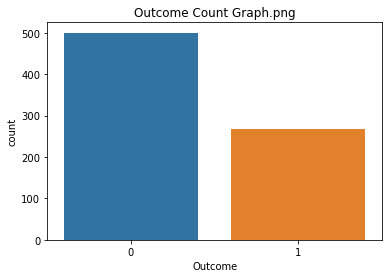

In [14]:
# Kategorik değişkenlerin incelenmesi

for col in categorical_cols:
    cat_summary(df, col,plot=True)

In [15]:
#Sayısal değişkenlerin incelenmesi

df[numerical_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: Pregnancies, dtype: float64


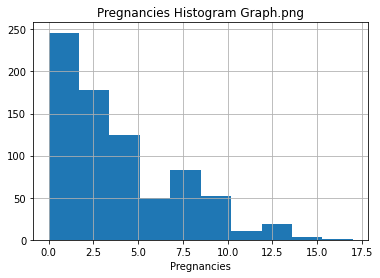

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
5%        79.000000
10%       85.000000
20%       95.000000
30%      102.000000
40%      109.000000
50%      117.000000
60%      125.000000
70%      134.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: Glucose, dtype: float64


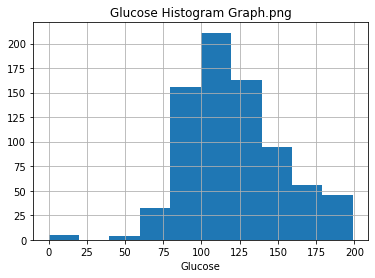

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
5%        38.700000
10%       54.000000
20%       60.000000
30%       64.000000
40%       68.000000
50%       72.000000
60%       74.000000
70%       78.000000
80%       82.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: BloodPressure, dtype: float64


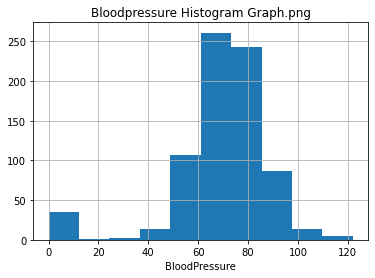

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        8.200000
40%       18.000000
50%       23.000000
60%       27.000000
70%       31.000000
80%       35.000000
90%       40.000000
95%       44.000000
99%       51.330000
max       99.000000
Name: SkinThickness, dtype: float64


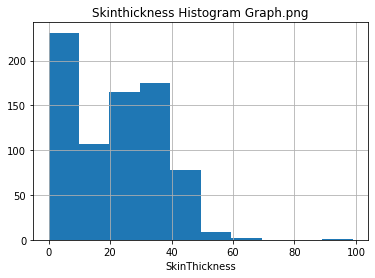

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%       30.500000
60%       72.200000
70%      106.000000
80%      150.000000
90%      210.000000
95%      293.000000
99%      519.900000
max      846.000000
Name: Insulin, dtype: float64


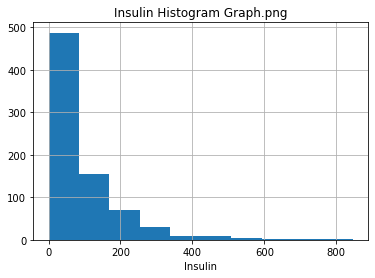

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
5%        21.800000
10%       23.600000
20%       25.900000
30%       28.200000
40%       30.100000
50%       32.000000
60%       33.700000
70%       35.490000
80%       37.800000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: BMI, dtype: float64


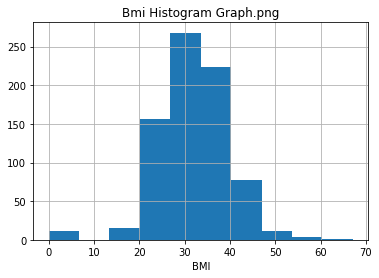

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
20%        0.219400
30%        0.259000
40%        0.302800
50%        0.372500
60%        0.454200
70%        0.563700
80%        0.687000
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64


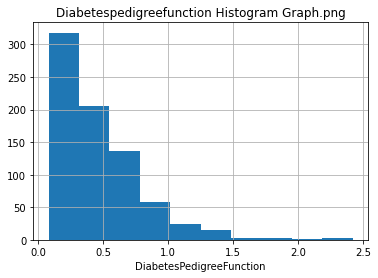

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
20%       23.000000
30%       25.000000
40%       27.000000
50%       29.000000
60%       33.000000
70%       38.000000
80%       42.600000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: Age, dtype: float64


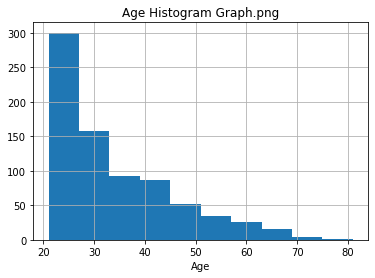

In [16]:
for col in numerical_cols:
    num_summary(dataframe=df,
                col_name= col,
                plot= True)

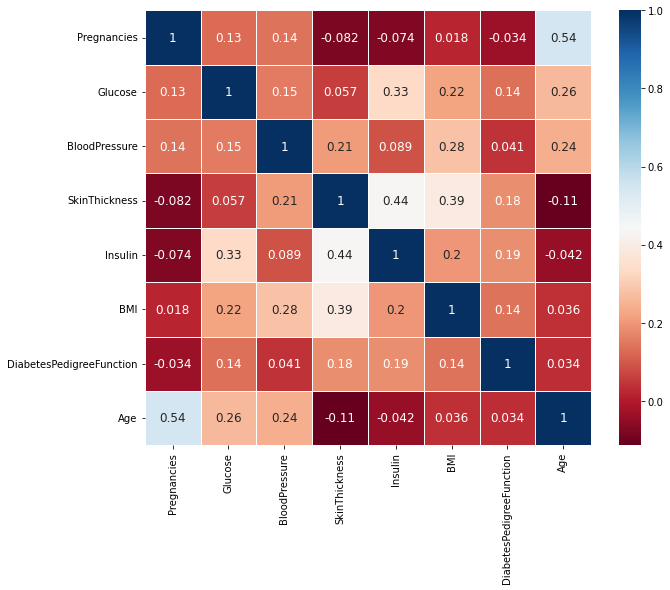

In [17]:
# Sayısal değişkenlerin birbiri ile korelasyonu

correlation_matrix(df, numerical_cols)

In [18]:
# Target ile sayısal değişkenlerin incelenmesi
for col in numerical_cols:
    target_summary_with_numerical_data(df, "Outcome", col)

         Pregnancies
Outcome             
0           3.298000
1           4.865672


            Glucose
Outcome            
0        109.980000
1        141.257463


         BloodPressure
Outcome               
0            68.184000
1            70.824627


         SkinThickness
Outcome               
0            19.664000
1            22.164179


            Insulin
Outcome            
0         68.792000
1        100.335821


               BMI
Outcome           
0        30.304200
1        35.142537


         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500


               Age
Outcome           
0        31.190000
1        37.067164




## Data Preprocessing & Feature Engineering

In [19]:
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    """
    Return the lower and upper limit of each columns. 

    Args:
        dataframe (dataframe): The dataframe from which variables names are to be retrieved.
        col_name (string): The column names from which features names are to be retrieved
        q1 (float, optional): _description_. Defaults to 0.25.
        q3 (float, optional): _description_. Defaults to 0.75.

    Returns:
        low_limit (float): Returns the lower limit by using quartile1 and interquantile range values for each columns.
        up_limit (float) : Returns the upper limit by using quartile3 and interquantile range values for each columns.
    """
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [20]:
def replace_with_thresholds(dataframe, col_name):
    """
    Replacing values ​​in Outlier with lower and upper bounds

    Args:
        dataframe (dataframe): The dataframe from which variables names are to be retrieved.
        col_name (string): The column name with the outlier values are to be retrieved.
    """
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    dataframe.loc[(dataframe[col_name] < low_limit), col_name] = low_limit
    dataframe.loc[(dataframe[col_name] > up_limit), col_name] = up_limit

In [21]:
def check_outlier(dataframe, col_name, q1=0.25, q3=0.75):
    """
    Checking the outliers for each columns

    Args:
        dataframe (dataframe): The dataframe from which variables names are to be retrieved.
        col_name (string): The column names from which features names are to be retrieved
        q1 (float, optional): Quartile 1 Value of specified column. Defaults to 0.25.
        q3 (float, optional): Quartile 3 Value of specified column.. Defaults to 0.75.

    Returns:
        boolean: If the specified column has outlier values, return True. If not, return False.
    """
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [22]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    """
    Apply One Hot Encoding to all specified categorical columns.

    Args:
        dataframe (dataframe): The dataframe from which variables names are to be retrieved.
        categorical_col (string): The numerical column names are to be retrieved.
        drop_first (bool, optional): Remove the first column after one hot encoding process to prevent overfitting. Defaults to False.

    Returns:
        _type_: _description_
    """
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [23]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [24]:
# Değişken isimleri büyütmek
df.columns = [col.upper() for col in df.columns]

In [25]:
# Glucose
df['NEW_GLUCOSE_CAT'] = pd.cut(x=df['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])
# 0 değerini kapsasın diye -1 yazdık.
# -1 ile 139 arasında normal, 139 ile 200 arasına prediabetes dedik.

In [26]:
# Age
df.loc[(df['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
df.loc[(df['AGE'] >= 35) & (df['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
df.loc[(df['AGE'] > 55), "NEW_AGE_CAT"] = 'old'

In [27]:
# BMI
df['NEW_BMI_RANGE'] = pd.cut(x=df['BMI'], 
                             bins=[-1, 18.5, 24.9, 29.9, 100],
                             labels=["underweight", "healthy", "overweight", "obese"])

In [28]:
# BloodPressure
df['NEW_BLOODPRESSURE'] = pd.cut(x=df['BLOODPRESSURE'], bins=[-1, 79, 89, 123], labels=["normal", "hs1", "hs2"])

In [29]:
check_df(df)

##################### Shape #####################
(768, 13)


##################### Types #####################
PREGNANCIES                    int64
GLUCOSE                        int64
BLOODPRESSURE                  int64
SKINTHICKNESS                  int64
INSULIN                        int64
BMI                          float64
DIABETESPEDIGREEFUNCTION     float64
AGE                            int64
OUTCOME                        int64
NEW_GLUCOSE_CAT             category
NEW_AGE_CAT                   object
NEW_BMI_RANGE               category
NEW_BLOODPRESSURE           category
dtype: object


##################### Head #####################
   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23 

In [30]:
categorical_cols, numerical_cols, cardinal_cols, nominal_cols = grab_col_names(df, categorical_threshold=5, cardinal_threshold=20)

Observations: 768
Variables: 13
categorical_cols: 5
numerical_cols: 8
cardinal_cols: 0
nominal_cols: 4


In [31]:
categorical_cols

['NEW_AGE_CAT',
 'OUTCOME',
 'NEW_GLUCOSE_CAT',
 'NEW_BMI_RANGE',
 'NEW_BLOODPRESSURE']

In [32]:
numerical_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE']

In [33]:
cardinal_cols

[]

In [34]:
nominal_cols

['OUTCOME', 'NEW_GLUCOSE_CAT', 'NEW_BMI_RANGE', 'NEW_BLOODPRESSURE']

           NEW_AGE_CAT      Ratio
young              488  63.541667
middleage          230  29.947917
old                 50   6.510417
########################################## 



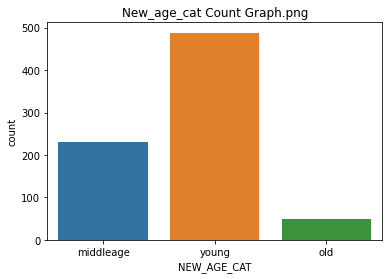

   OUTCOME      Ratio
0      500  65.104167
1      268  34.895833
########################################## 



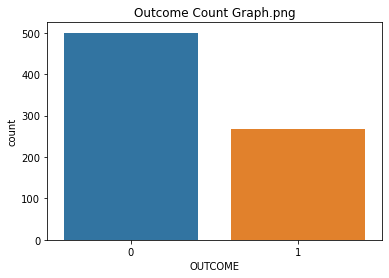

             NEW_GLUCOSE_CAT      Ratio
normal                   571  74.348958
prediabetes              197  25.651042
########################################## 



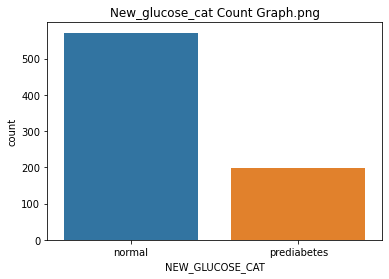

             NEW_BMI_RANGE      Ratio
obese                  472  61.458333
overweight             179  23.307292
healthy                102  13.281250
underweight             15   1.953125
########################################## 



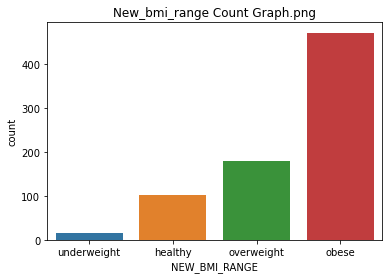

        NEW_BLOODPRESSURE      Ratio
normal                563  73.307292
hs1                   145  18.880208
hs2                    60   7.812500
########################################## 



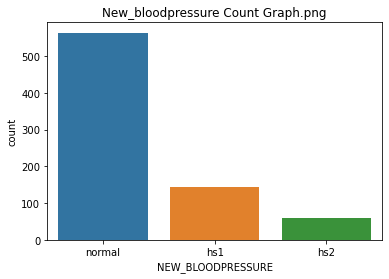

In [35]:
for col in categorical_cols:
    cat_summary(df,col,True)

In [36]:
for col in categorical_cols:
    target_summary_with_categorical_data(df, "OUTCOME",col)

             TARGET_MEAN
NEW_AGE_CAT             
middleage       0.543478
old             0.340000
young           0.258197


         TARGET_MEAN
OUTCOME             
0                0.0
1                1.0


                 TARGET_MEAN
NEW_GLUCOSE_CAT             
normal              0.232925
prediabetes         0.685279


               TARGET_MEAN
NEW_BMI_RANGE             
underweight       0.133333
healthy           0.068627
overweight        0.223464
obese             0.463983


                   TARGET_MEAN
NEW_BLOODPRESSURE             
normal                0.316163
hs1                   0.420690
hs2                   0.483333




In [37]:
categorical_cols = [col for col in categorical_cols if "OUTCOME" not in col]

In [38]:
df = one_hot_encoder(df, categorical_cols, drop_first=True)

In [39]:
check_df(df)

##################### Shape #####################
(768, 17)


##################### Types #####################
PREGNANCIES                      int64
GLUCOSE                          int64
BLOODPRESSURE                    int64
SKINTHICKNESS                    int64
INSULIN                          int64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                              int64
OUTCOME                          int64
NEW_AGE_CAT_old                  uint8
NEW_AGE_CAT_young                uint8
NEW_GLUCOSE_CAT_prediabetes      uint8
NEW_BMI_RANGE_healthy            uint8
NEW_BMI_RANGE_overweight         uint8
NEW_BMI_RANGE_obese              uint8
NEW_BLOODPRESSURE_hs1            uint8
NEW_BLOODPRESSURE_hs2            uint8
dtype: object


##################### Head #####################
   PREGNANCIES  GLUCOSE  BLOODPRESSURE  SKINTHICKNESS  INSULIN   BMI  \
0            6      148             72             35        0  33.6   
1            1  

In [40]:
df.columns = [col.upper() for col in df.columns]

In [41]:
# Son final değişken türleri
categorical_cols, numerical_cols, cardinal_cols, ordinal_cols = grab_col_names(df,
                                                                               categorical_threshold=5,
                                                                               cardinal_threshold=20)

Observations: 768
Variables: 17
categorical_cols: 9
numerical_cols: 8
cardinal_cols: 0
nominal_cols: 9


In [42]:
categorical_cols = [col for col in categorical_cols if "OUTCOME" not in col]

In [43]:
for col in numerical_cols:
    print(col, check_outlier(dataframe=df,
                             col_name = col,
                             q1 = 0.05,
                             q3 = 0.95))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN True
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


In [44]:
replace_with_thresholds(df, "INSULIN")

In [45]:
# Standartlaştırma
X_scaled = StandardScaler().fit_transform(df[numerical_cols])
df[numerical_cols] = pd.DataFrame(X_scaled, columns=df[numerical_cols].columns)

In [46]:
y = df["OUTCOME"]
X = df.drop(["OUTCOME"], axis=1)

In [47]:
check_df(X)

##################### Shape #####################
(768, 16)


##################### Types #####################
PREGNANCIES                    float64
GLUCOSE                        float64
BLOODPRESSURE                  float64
SKINTHICKNESS                  float64
INSULIN                        float64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                            float64
NEW_AGE_CAT_OLD                  uint8
NEW_AGE_CAT_YOUNG                uint8
NEW_GLUCOSE_CAT_PREDIABETES      uint8
NEW_BMI_RANGE_HEALTHY            uint8
NEW_BMI_RANGE_OVERWEIGHT         uint8
NEW_BMI_RANGE_OBESE              uint8
NEW_BLOODPRESSURE_HS1            uint8
NEW_BLOODPRESSURE_HS2            uint8
dtype: object


##################### Head #####################
   PREGNANCIES   GLUCOSE  BLOODPRESSURE  SKINTHICKNESS   INSULIN       BMI  \
0     0.639947  0.848324       0.149641       0.907270 -0.787602  0.204013   
1    -0.844885 -1.123396      -0.160546    

In [48]:
def diabetes_data_prep(dataframe):
    """
    The whole Data Preprocessing steps for Diabetes csv file. 

    Args:
        dataframe (dataframe): The dataframe from which variables names are to be retrieved.

    Returns:
        X (dataframe): Return the whole dataset without target column after data preprocessing
        y (list): Return the target column
    """
    dataframe.columns = [col.upper() for col in dataframe.columns]

    # Glucose
    dataframe['NEW_GLUCOSE_CAT'] = pd.cut(x=dataframe['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])

    # Age
    dataframe.loc[(dataframe['AGE'] < 35), "NEW_AGE_CAT"] = 'young'
    dataframe.loc[(dataframe['AGE'] >= 35) & (dataframe['AGE'] <= 55), "NEW_AGE_CAT"] = 'middleage'
    dataframe.loc[(dataframe['AGE'] > 55), "NEW_AGE_CAT"] = 'old'

    # BMI
    dataframe['NEW_BMI_RANGE'] = pd.cut(x=dataframe['BMI'], bins=[-1, 18.5, 24.9, 29.9, 100],
                                        labels=["underweight", "healty", "overweight", "obese"])

    # BloodPressure
    dataframe['NEW_BLOODPRESSURE'] = pd.cut(x=dataframe['BLOODPRESSURE'], bins=[-1, 79, 89, 123],
                                            labels=["normal", "hs1", "hs2"])

    categorical_cols, numerical_cols, cardinal_cols, nominal_cols = grab_col_names(dataframe, categorical_threshold=5, cardinal_threshold=20)

    categorical_cols = [col for col in categorical_cols if "OUTCOME" not in col]

    df = one_hot_encoder(dataframe, categorical_cols, drop_first=True)

    df.columns = [col.upper() for col in df.columns]

    print("\n")
    print("After Feature Extraction and Encoding Process \n")
    
    categorical_cols, numerical_cols, cardinal_cols, nominal_cols = grab_col_names(df, categorical_threshold=5, cardinal_threshold=20)

    categorical_cols = [col for col in categorical_cols if "OUTCOME" not in col]

    replace_with_thresholds(df, "INSULIN")

    X_scaled = StandardScaler().fit_transform(df[numerical_cols])
    df[numerical_cols] = pd.DataFrame(X_scaled, columns=df[numerical_cols].columns)

    y = df["OUTCOME"]
    X = df.drop(["OUTCOME"], axis=1)

    return X, y

In [49]:
df = pd.read_csv("datasets/diabetes.csv")

In [50]:
check_df(df)

##################### Shape #####################
(768, 9)


##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object


##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0

In [51]:
X, y = diabetes_data_prep(df)

Observations: 768
Variables: 13
categorical_cols: 5
numerical_cols: 8
cardinal_cols: 0
nominal_cols: 4


After Feature Extraction and Encoding Process 

Observations: 768
Variables: 17
categorical_cols: 9
numerical_cols: 8
cardinal_cols: 0
nominal_cols: 9


In [52]:
check_df(X)

##################### Shape #####################
(768, 16)


##################### Types #####################
PREGNANCIES                    float64
GLUCOSE                        float64
BLOODPRESSURE                  float64
SKINTHICKNESS                  float64
INSULIN                        float64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                            float64
NEW_AGE_CAT_OLD                  uint8
NEW_AGE_CAT_YOUNG                uint8
NEW_GLUCOSE_CAT_PREDIABETES      uint8
NEW_BMI_RANGE_HEALTY             uint8
NEW_BMI_RANGE_OVERWEIGHT         uint8
NEW_BMI_RANGE_OBESE              uint8
NEW_BLOODPRESSURE_HS1            uint8
NEW_BLOODPRESSURE_HS2            uint8
dtype: object


##################### Head #####################
   PREGNANCIES   GLUCOSE  BLOODPRESSURE  SKINTHICKNESS   INSULIN       BMI  \
0     0.639947  0.848324       0.149641       0.907270 -0.787602  0.204013   
1    -0.844885 -1.123396      -0.160546    

## Base Models

- Research aşamasında da yer alabilir, veya Pipeline içerisinde raporlama kısmında da yer alabilir. Ama genelde Pipeline içerisinde yer almaması gereken bir bölümdür.
- Research aşamasında temel bazı modellere bakılır. Bu modeller içerisinde bu problemi çözmek için kullanabilecek olanlar arasından 1 veya 1'den fazla model seçilir ve onların üzerinde hiper parametre optimizasyonu  gerçekleştirilir.
  - LightGBM (Gradient temelli) gibi modeller genellikle en iyi modeller olarak seçilir. 

In [53]:
def base_models(X,y, scoring="roc_auc"):
    """
    Print the results of specified models without any data processing steps.

    Args:
        X (dataframe): Return the whole dataset without target column after data preprocessing
        y (list): Return the target column
        scoring (str, optional): It contains the information of what type of model results are desired. Defaults to "roc_auc".
    """
    print("Base Models .... \n")
    classifiers = [("LR", LogisticRegression()),
                   ("KNN",KNeighborsClassifier()),
                   ("SVC",SVC()),
                   ("CART",DecisionTreeClassifier()),
                   ("RF",RandomForestClassifier()),
                   ("Adaboost",AdaBoostClassifier()),
                   ("GBM",GradientBoostingClassifier()),
                   ("XGBoost",XGBClassifier(use_label_encoder=False, eval_metric = "logloss")),
                   ("LightGBM",LGBMClassifier()),
                   ("CatBoost",CatBoostClassifier(verbose=False))]
    
    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X,y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name}) ")

In [54]:
base_models(X,y, scoring="accuracy")

Base Models .... 

accuracy: 0.7604 (LR) 
accuracy: 0.7617 (KNN) 
accuracy: 0.7656 (SVC) 
accuracy: 0.6784 (CART) 
accuracy: 0.763 (RF) 
accuracy: 0.7578 (Adaboost) 
accuracy: 0.75 (GBM) 
accuracy: 0.7448 (XGBoost) 
accuracy: 0.7383 (LightGBM) 
accuracy: 0.7591 (CatBoost) 


## Automated Hyperparamater Optimization

In [55]:
knn_params = {"n_neighbors": range(2, 50)}

In [56]:
cart_params = {'max_depth': range(1, 20),
               "min_samples_split": range(2, 30)}

In [57]:
rf_params = {"max_depth": [8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [15, 20],
             "n_estimators": [200, 300]}

In [58]:
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 200]}

In [59]:
lightgbm_params = {"learning_rate": [0.01, 0.1],
                   "n_estimators": [300, 500]}

In [60]:
classifiers = [('KNN', KNeighborsClassifier(), knn_params),
               ("CART", DecisionTreeClassifier(), cart_params),
               ("RF", RandomForestClassifier(), rf_params),
               ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
               ('LightGBM', LGBMClassifier(), lightgbm_params)]

In [61]:
def hyperparamater_optimization(X,y,cv=3, scoring="roc_auc"):
    """
    Return the best models after hyperparameter optimization process

    Args:
        X (dataframe): Return the whole dataset without target column after data preprocessing
        y (list): Return the target column
        cv (int, optional): The number for cross validation. Defaults to 3.
        scoring (str, optional): It contains the information of what type of model results are desired. Defaults to "roc_auc".

    Returns:
        _type_: _description_
    """
    print("Hyperparameter Optimization ...")
    best_models= {}
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(estimator=classifier,
                                    X=X,
                                    y=y,
                                    cv=cv,
                                    scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")
        
        gs_best = GridSearchCV(estimator=classifier,
                               param_grid=params, 
                               cv=cv, 
                               n_jobs=-1, 
                               verbose= False).fit(X,y)
        final_model = classifier.set_params(**gs_best.best_params_)
        
        cv_results= cross_validate(estimator=final_model,
                                   X=X,
                                   y=y,
                                   cv=cv,
                                   scoring=scoring)
        
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

In [62]:
best_models = hyperparamater_optimization(X,y)

Hyperparameter Optimization ...
########## KNN ##########
roc_auc (Before): 0.791
roc_auc (After): 0.8211
KNN best params: {'n_neighbors': 20}

########## CART ##########
roc_auc (Before): 0.6527
roc_auc (After): 0.7943
CART best params: {'max_depth': 6, 'min_samples_split': 23}

########## RF ##########
roc_auc (Before): 0.8264
roc_auc (After): 0.8333
RF best params: {'max_depth': 15, 'max_features': 7, 'min_samples_split': 15, 'n_estimators': 200}

########## XGBoost ##########
roc_auc (Before): 0.8015
roc_auc (After): 0.8179
XGBoost best params: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200}

########## LightGBM ##########
roc_auc (Before): 0.807
roc_auc (After): 0.8185
LightGBM best params: {'learning_rate': 0.01, 'n_estimators': 300}



## Stacking & Ensemble Learning

- Birden fazla modeli bir arada kullanmaya dayanmaktadır.
- Random Forest içerisinde birden fazla ağacın farklı olarak çalışıp sonrasında tek bir ağaç gibi davranmaları bagging olayına örnekti. Burada ise, sadece Random Forest değil, başka algoritmalarla birlikte ortak bir sonuç oluşturulur.
-  Bir algoritmanın kendi içindeki çalışma prensibi yerine, birden fazla algoritmanın bir araya gelerek bu işlemleri yapmasına Stacking | Ensemble | Meta Learning denir.
-  Tahmin performansının güçlenmesi beklenir.

In [63]:
def voting_classifier(best_models, X, y):
    """
    Calculate and return the voting classification by using top 3 best models for this dataset.
    
    Args:
        best_models (dictionary): The dictionary of best model with hyperparameter values.
        X (dataframe): Return the whole dataset without target column after data preprocessing.
        y (list): Return the target column.
    
    """
    print("Voting Classifier...")
    
    """ Soft Voting / Majority Rule Classifier for unfitted estimators
    
    Hard Voting : Uses predicted class labels for majority rule voting
        - Diyelim ki 3 model arasından 2'si 1 olarak tahmin etti, birisi 0 olarak tahmin etti. O zaman hard voting kuralına göre çoğunluk ele alınır ve tahmin sonucu 1 olarak alınır.
    Soft Voting : Uses predicted class labels based on the argmax of the sums of the predicted probabilities
        - Sınıf gerçekleşme olasılıkları üzerinden oylama yapılır.
    
    """
    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]),
                                              ('RF', best_models["RF"]), # bagging'e dayalı
                                              ('LightGBM', best_models["LightGBM"])], #boosting'e dayalı
                                  voting='soft').fit(X, y)

    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

In [64]:
voting_clf = voting_classifier(best_models, X, y)

Voting Classifier...
Accuracy: 0.7669270833333334
F1Score: 0.6313041758833416
ROC_AUC: 0.8358322898147271


## Prediction for a New Observation

In [65]:
X.columns
random_user = X.sample(1, random_state=45)
voting_clf.predict(random_user)

array([1], dtype=int64)

In [66]:
joblib.dump(voting_clf, "voting_clf2.pkl")

['voting_clf2.pkl']

In [67]:
new_model = joblib.load("voting_clf2.pkl")
new_model.predict(random_user)

array([1], dtype=int64)

## Pipeline Main Function

- ***config.py*** : Konfigurasyon dosyası: 
  - Veri setinin path'i yer alabilir. Dışarıdan ayarlanan ifadeler burada olabilir.
  - Oluşturulan parametre ifadeleri burada yer alabilir.
    - knn_params, cart_params, vb.
    - output path
    - log tutulabilir. (geçmiş bilgiler)

In [68]:
def main():
    """
    Main function to start end-to-end machine learning pipeline process

    Returns:
        voting_clf (): Return 3 best models with hyperparameter values after Voting Classification process.
        """
    df = pd.read_csv("datasets/diabetes.csv")
    X, y = diabetes_data_prep(df)
    print("\n")
    base_models(X,y)
    print("\n")
    best_models = hyperparamater_optimization(X,y)
    print("\n")
    voting_clf = voting_classifier(best_models, X, y)
    joblib.dump(voting_clf, "voting_clf.pkl")
    return voting_clf

if __name__ == "__main__":
    print("Process started...")
    main()

Process started...
Observations: 768
Variables: 13
categorical_cols: 5
numerical_cols: 8
cardinal_cols: 0
nominal_cols: 4


After Feature Extraction and Encoding Process 

Observations: 768
Variables: 17
categorical_cols: 9
numerical_cols: 8
cardinal_cols: 0
nominal_cols: 9


Base Models .... 

roc_auc: 0.8409 (LR) 
roc_auc: 0.791 (KNN) 
roc_auc: 0.8355 (SVC) 
roc_auc: 0.6615 (CART) 
roc_auc: 0.8314 (RF) 
roc_auc: 0.8196 (Adaboost) 
roc_auc: 0.8238 (GBM) 
roc_auc: 0.8015 (XGBoost) 
roc_auc: 0.807 (LightGBM) 
roc_auc: 0.8349 (CatBoost) 


Hyperparameter Optimization ...
########## KNN ##########
roc_auc (Before): 0.8211
roc_auc (After): 0.8211
KNN best params: {'n_neighbors': 20}

########## CART ##########
roc_auc (Before): 0.7943
roc_auc (After): 0.7943
CART best params: {'max_depth': 6, 'min_samples_split': 23}

########## RF ##########
roc_auc (Before): 0.835
roc_auc (After): 0.8358
RF best params: {'max_depth': 15, 'max_features': 5, 'min_samples_split': 15, 'n_estimators': 300}

#

## Prediction

- Bazı kaynaklarda scoring olara da geçebilir.

In [69]:
import joblib
import pandas as pd

In [70]:
df = pd.read_csv("datasets/diabetes.csv")

In [71]:
random_user = df.sample(1, random_state=45)

In [72]:
new_model = joblib.load("voting_clf.pkl")

In [73]:
new_model.predict(random_user)
# Burada hata çıkmasının nedeni modeli kurduğumuz veri seti ile dışarıdan aldığımız veri setinin arasındaki boyut farklılığıdır. 
# Bu hata data preprocessing kısmında yaptığımız feature extraction kısmında kaynaklanır. 
# Bunu düzeltmek için öncelikle diabetes_data_prep fonksiyonunu kullanarak veri seti boyutunu modelde yeniden oluşturduğumuz veri seti boyutuna uyarlanması gerekir.

ValueError: X has 9 features, but KNeighborsClassifier is expecting 16 features as input.

In [74]:
X, y = diabetes_data_prep(df)

Observations: 768
Variables: 13
categorical_cols: 5
numerical_cols: 8
cardinal_cols: 0
nominal_cols: 4


After Feature Extraction and Encoding Process 

Observations: 768
Variables: 17
categorical_cols: 9
numerical_cols: 8
cardinal_cols: 0
nominal_cols: 9


In [76]:
random_user = X.sample(1, random_state=50)

In [77]:
new_model = joblib.load("voting_clf.pkl")

In [78]:
new_model.predict(random_user)

array([0], dtype=int64)